<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
     <img style="float: right; padding-right: 10px" width="100" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>
     </div>

**Clemson University**<br>
**Instructor(s):** Aaron Masino <br>

## Lab 11: Frequent Itemsets and Association Rules

This lab will introduce you to frequent items set mining using the mlxtend library.

By the end of this lab, you should be able to:
- apply the apriori method to obtain frequent itemsets from a transactional database record
- apply the association rules method to obtain association rules from a frequent itemset list
- evaluate association rules with visualization methods
- apply pruning methods to refine association rules 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from pandas.plotting import parallel_coordinates
import os

# Grocery Dataset

In this lab, we will be examining a dataset representing grocery purchases. Each entry of the dataset represents a transaction involving the purchase of one or more grocery items. This is the canonical market basket problem. We will be mining this dataset to identify frequent itemsets, that is, sets of items that are frequenlty purchased together. We use the frequent item set information to identify association rules. 

First, let's take a look at the datase by loading it into a Pandas DataFrame. We see that each row contains the number of items purchashed in the transaction (the _Item(s)_ column) and the items purchased.

In [2]:
file_groceries = os.path.join('..', 'data', 'grocery-baskets.csv')
# read in the first 5 rows of the groceries dataset
df_groceries = pd.read_csv(file_groceries)
df_groceries.head()

,Item(s),Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,...,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32
0,4,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The DataFrame is not organized as needed for our frequent itemset mining task. We need the data instead to be organized with columns indicating a specific item (e.g., _yogurt_) and the column value indicating if that item was purchased in the given transaction. In other words, our data should look like the following:

| Index | Milk | Yogurt | Fruit |
|-------|------|--------|-------|
| 0     | 0    | 1      | 1     |
| 1     | 1    | 1      | 1     |
| 2     | 1    | 0      | 1     |

Let's reorganize the data using the _apply_ method to process the DataFrame rows.

In [3]:
records = []
def collect_rows(row):
    records.append([str(row.values[j]) for j in range(1, row.values[0]+1)])

df_groceries.apply(collect_rows, axis=1)
records[0:5]

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'],
 ['tropical fruit', 'yogurt', 'coffee'],
 ['whole milk'],
 ['pip fruit', 'yogurt', 'cream cheese', 'meat spreads'],
 ['other vegetables',
  'whole milk',
  'condensed milk',
  'long life bakery product']]

Before we use the `records` for frequent itemset mining, let's first take a look at some of their characteristics.

In [4]:
counts = [len(record) for record in records]
print(f'50 percent of the transactions include {np.quantile(counts, .5)} or fewer items.')
print(f'95 percent of the transactions include {np.quantile(counts, .95)} or fewer items.')
print(f'The largest transaciton includes {np.max(counts)} items.')

50 percent of the transactions include 3.0 or fewer items.
95 percent of the transactions include 11.0 or fewer items.
The largest transaciton includes 32 items.


We will be using the [MLXtend](https://rasbt.github.io/mlxtend/) library to perform frequent itemset and association rule mining (there are alternatives, e.g., [scikit-mine](https://scikit-mine.github.io/scikit-mine/index.html)). We will use the `TransactionEncoder` class to construct a _onehot_ representation of the transaction records and then use that to create the Pandas DataFrame.

In [5]:
te = TransactionEncoder()
onehot = te.fit_transform(records)
onehot = pd.DataFrame(onehot, columns = te.columns_)

print(f'Shape of encoded data: {onehot.shape[0]} rows and {onehot.shape[1]} columns')
onehot.head()

Shape of encoded data: 9835 rows and 169 columns


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [6]:
# for each column in the onehot dataframe, sum the number of times the item was purchased
item_counts = onehot.sum().sort_values(ascending=False)
item_counts.head()
# print the median number of times an item was purchased
print(f'The median number of times an item was purchased is {np.median(item_counts)}')

# print the 75% quantile of the number of times an item was purchased
print(f'The 75% quantile of the number of times an item was purchased is {np.quantile(item_counts, .75)}')

# create a list of items purchased more than the 75% quantile number of times
top_items = item_counts[item_counts > np.quantile(item_counts, .5)].index.tolist()
print(len(top_items))
# # create a list of items purchased more than the median number of times
# top_items = item_counts[item_counts > np.median(item_counts)].index.tolist()
print(len(top_items))
print(top_items)



The median number of times an item was purchased is 103.0
The 75% quantile of the number of times an item was purchased is 305.0
84
84
['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt', 'bottled water', 'root vegetables', 'tropical fruit', 'shopping bags', 'sausage', 'pastry', 'citrus fruit', 'bottled beer', 'newspapers', 'canned beer', 'pip fruit', 'fruit/vegetable juice', 'whipped/sour cream', 'brown bread', 'domestic eggs', 'frankfurter', 'margarine', 'coffee', 'pork', 'butter', 'curd', 'beef', 'napkins', 'chocolate', 'frozen vegetables', 'chicken', 'white bread', 'cream cheese', 'waffles', 'salty snack', 'long life bakery product', 'dessert', 'sugar', 'UHT-milk', 'hamburger meat', 'berries', 'hygiene articles', 'onions', 'specialty chocolate', 'candy', 'misc. beverages', 'frozen meals', 'oil', 'butter milk', 'specialty bar', 'ham', 'beverages', 'meat', 'ice cream', 'hard cheese', 'sliced cheese', 'cat food', 'grapes', 'chewing gum', 'red/blush wine', 'detergent', 'w

We can now use the `apriori` function from `mlxtend` to identify the frequent itemsets from our transaction data. 

In [7]:

onehot_for_rules = onehot.loc[:, top_items]

frequent_itemsets=apriori(onehot_for_rules, min_support=0.0001, use_colnames=True, max_len=3)
frequent_itemsets

,support,itemsets
0,0.255516,(whole milk)
1,0.193493,(other vegetables)
2,0.183935,(rolls/buns)
3,0.174377,(soda)
4,0.139502,(yogurt)
...,...,...
65959,0.000102,"(mustard, canned vegetables, salt)"
65960,0.000102,"(mustard, frozen dessert, salt)"
65961,0.000102,"(spread cheese, canned vegetables, cling film/..."
65962,0.000102,"(canned vegetables, salt, cling film/bags)"


Now that we have the frequent itemsets, we use the `association_rules` method from the `mlextend` library.

In [8]:
rules=association_rules(frequent_itemsets)
print(f'There are {rules.shape[0]} rules identified.')
rules.head()

There are 928 rules identified.


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(herbs, rolls/buns)",(whole milk),0.003050,0.255516,0.002440,0.800000,3.130919,0.001661,3.722420,0.682687
1,"(herbs, tropical fruit)",(whole milk),0.002847,0.255516,0.002339,0.821429,3.214783,0.001611,4.169110,0.690904
2,"(pastry, herbs)",(whole milk),0.000712,0.255516,0.000610,0.857143,3.354556,0.000428,5.211388,0.702398
3,"(bottled beer, hamburger meat)",(whole milk),0.002135,0.255516,0.001729,0.809524,3.168192,0.001183,3.908541,0.685827
4,"(frozen fish, whipped/sour cream)",(whole milk),0.000712,0.255516,0.000610,0.857143,3.354556,0.000428,5.211388,0.702398


Notice there are a number of features in the `rules` DataFrame. These include three measures that we will consider:

* Support
* Confidence
* Lift

**Let's examine these through an example. Suppose we have 2000 customer transactions in a supermarket. Let's consider the Support, Confidence, and Lift for two items, say bread and jam.**
Out of the 2000 transactions, 200 contain jam whereas 300 contain bread. These 300 transactions include 100 that include both bread and jam. Using this data, we shall find out the support, confidence, and lift.
#### SUPPORT
Support is the default popularity of any itemd defined by the the division of the number of transactions containing that item by the total number of transactions. Hence, in our example,

* Support (Jam) = (Transactions involving jam) / (Total Transactions)

                       *  = 200/2000 = 0.1
* Support (Bread) = (Transactions involving bread) / (Total Transactions)

                       *  = 300/2000 = 0.15
* Support (Jam & Bread) = (Transactions involving jam & bread) / (Total Transactions)

                       *  = 100/2000 = 0.05
#### Confidence 
Confidence indicates the ikelihood that an itemset $X$ occurs with another itemset $Y$ relative to the occurence of $X$. In this example, it's the likelihood that jam and bread are purchased together as compared to jam being purchased either alone or with other items not including bread. Dividing the number of transactions that include both bread and jam by the total number of transactions with jam will give the Confidence figure.

* Confidence(jam $\rightarrow$ bread) = Support(jam & bread) / Support(jam) 

                    = 0.05 / 0.1 =  0.5                     
                       
  * It implies that 50% of customers who bought jam bought bread as well
  
####  Lift
**Lift is a comparison of the observed confidence (i.e., the confidence found in the data) to the expected confidence. The "expected confidence" refers to the probability of the consequent item occurring in a transaction, assuming no association exists between the antecedent and consequent items. Lift indicates how much more likely an item is to appear with another item compared to what would be expected if the items were completely independent. In our example,**

* Lift(jam $\rightarrow$ bread)= Confidence(jam $\rightarrow$ bread) / (Support (bread))

      = 0.5 / 0.15  = 3.33

It says that the likelihood of a customer buying both jam and bread together is 3.33 times more likely than what would be expected if the items were independent. A lift value greater than 1 indicates a positive association (items are more likely to occur together than expected), while a lift value less than 1 indicates a negative association (items are less likely to occur together than expected).

### Visualizing Rules
We can get a high level assessment of the rules through visualizaitons. First, we can plot a scatter plot indicating the relation between support and confidence of the rules. In this plot, jitter has been added to address the issue that many rules have the same confidence and support in this dataset.

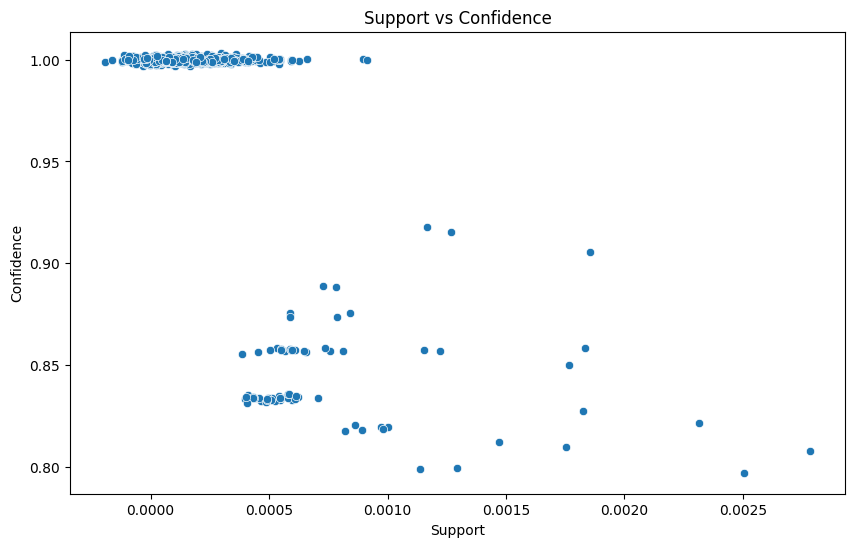

In [9]:
# create a scatttr plot of the rule support and confidence
plt.figure(figsize=(10,6))
# include some jitter to the plot so that points do not overlap
def jitter(values,j,s):
    return values + np.random.normal(j,s,values.shape)
sns.scatterplot(x=jitter(rules.support,0,0.0001), y=jitter(rules.confidence,0,0.001))
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')
plt.show()

We can also examine a _parallel coordinates_ plot to see how the rules relate with respect to support, confidence and lift.

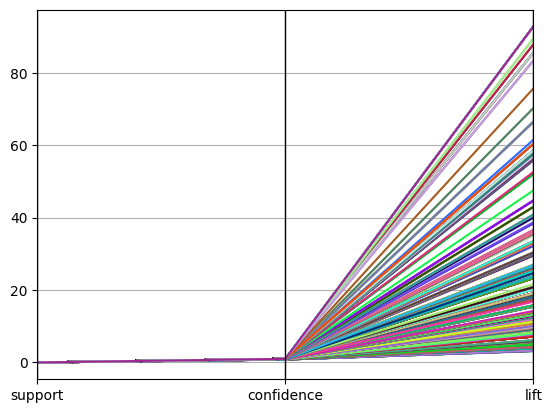

In [10]:
rules_df = pd.DataFrame(data={
    "rule": rules.index, 
    "support": rules["support"], 
    "confidence": rules["confidence"], 
    "lift": rules["lift"]
})
pc = parallel_coordinates(rules_df, 'rule')
plt.gca().legend_.remove()

### Pruning Rules

#### Rules with high confidence and lift
Now that we understand the metrics, let's use them to select high confidence and high lift rules.

In [11]:
l = 50
rules_high_conf = rules[(rules['confidence']>=0.99) & (rules['lift'] > l)]
# sort the rules by consequent support
print(f'There are {rules_high_conf.shape[0]} rules with confidence >= 0.99 and lift > {l}.')
rules_high_conf = rules_high_conf.sort_values(by='consequent support', ascending=True)
rules_high_conf.head(20)

There are 79 rules with confidence >= 0.99 and lift > 50.


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
927,"(spread cheese, cling film/bags)",(canned vegetables),0.000102,0.010778,0.000102,1.0,92.783019,0.000101,inf,0.989323
902,"(pickled vegetables, salt)",(canned vegetables),0.000102,0.010778,0.000102,1.0,92.783019,0.000101,inf,0.989323
896,"(mustard, white wine)",(salt),0.000102,0.010778,0.000102,1.0,92.783019,0.000101,inf,0.989323
895,"(mustard, white wine)",(canned vegetables),0.000102,0.010778,0.000102,1.0,92.783019,0.000101,inf,0.989323
892,"(herbs, white wine)",(salt),0.000102,0.010778,0.000102,1.0,92.783019,0.000101,inf,0.989323
926,"(seasonal products, cling film/bags)",(frozen dessert),0.000102,0.010778,0.000102,1.0,92.783019,0.000101,inf,0.989323
922,"(herbs, frozen fish)",(salt),0.000102,0.010778,0.000102,1.0,92.783019,0.000101,inf,0.989323
924,"(pasta, frozen fish)",(frozen dessert),0.000102,0.010778,0.000102,1.0,92.783019,0.000101,inf,0.989323
920,"(processed cheese, frozen fish)",(spread cheese),0.000102,0.011185,0.000102,1.0,89.409091,0.000101,inf,0.988916
910,"(cake bar, baking powder)",(spread cheese),0.000102,0.011185,0.000102,1.0,89.409091,0.000101,inf,0.988916


#### Target rules
We can prune the rules further by selecting rules with certain consequents. For example, suppose our grocery market has poor sales of _frozen fish_ (really, who likes frozen fish?). Maybe we can use the association rules to place items near frozen fish that will help increase sales.

In [12]:
# get rules where the consequent is 'frozen fish'
rules_frozen_fish = rules[rules['consequents'] == {'frozen fish'}].reset_index(drop=True)
rules_frozen_fish = rules_frozen_fish.sort_values(by='confidence', ascending=False)
print(f'There are {rules_frozen_fish.shape[0]} rules with frozen fish as the consequent')
rules_frozen_fish.head()

There are 5 rules with frozen fish as the consequent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(frozen dessert, canned beer)",(frozen fish),0.000102,0.011693,0.000102,1.0,85.521739,0.000100,inf,0.988408
1,"(spread cheese, candy)",(frozen fish),0.000102,0.011693,0.000102,1.0,85.521739,0.000100,inf,0.988408
2,"(beverages, canned vegetables)",(frozen fish),0.000102,0.011693,0.000102,1.0,85.521739,0.000100,inf,0.988408
3,"(seasonal products, red/blush wine)",(frozen fish),0.000203,0.011693,0.000203,1.0,85.521739,0.000201,inf,0.988508
4,"(flour, spread cheese)",(frozen fish),0.000102,0.011693,0.000102,1.0,85.521739,0.000100,inf,0.988408
